In [1]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
 
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D,Conv2D
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, TimeDistributed, MaxPooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from keras.utils import to_categorical, normalize
import talib as ta
import psycopg2
from configparser import ConfigParser
plt.style.use('fivethirtyeight')

# pd.options.display.max_columns = 50  # None -> No Restrictions
# pd.options.display.max_rows = 200    # None -> Be careful with this 
# pd.options.display.max_colwidth = 100
# pd.options.display.precision = 3

print ('import completed')

Using TensorFlow backend.
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kriz_\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

import completed


In [117]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
#timesteps per samples
Enrol_window = 1

print ('enrol window set to',Enrol_window )

enrol window set to 1


In [49]:
# Support functions
scaler = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))
std_scaler = StandardScaler()


# for multivariate, nth timesteps output is used for n timesteps input so first output before nth is not used (Multiple Input Series)
def split_multi(sequences, n_steps):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix, -1])
        
    return np.array(X), np.array(y)

def split_multi_output(sequences, n_steps_in, n_steps_out):
    sequences = sequences.to_numpy()
#     print(sequences)
    
    X, y = [], []
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        X.append(sequences[i:end_ix, :-1])
        y.append(sequences[end_ix:out_end_ix, -1])
        
    return np.array(X), np.array(y)
                           
#for univariate(1 feature)
def split_uni(sequences, n_steps,normalise_window):
    sequence_length = n_steps + 1
    result = []
    for index in range(len(sequences) - sequence_length):
        result.append(sequences[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    return np.array(result)
                           
def load_data(datasetname, column, seq_len, normalise_window, n_outputs):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]
    
    row = round(0.8 * data.shape[0])
    
    if normalise_window:
#         data = std_scaler.fit_transform(data)
        data = scaler.fit_transform(data)
    
    data = pd.DataFrame(data,columns = column)
    
    data_train = data[:int(row)]
    data_test = data[int(row):]
    
#     if normalise_window:
#         data_train = std_scaler.fit_transform(data_train)
#         data_test = std_scaler.transform(data_test)
        
#         data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
#           data_train = scaler.fit_transform(data_train)
#         data_test = scaler.transform(data_test)
# scaler_y = MinMaxScaler(feature_range=(0,1))
        
    
#     data = pd.DataFrame(data,columns = column)
#     data_test = pd.DataFrame(data_test,columns = data.columns)
    
    print(data.describe())
    
    x_train, y_train = split_multi_output(data_train, seq_len, n_outputs)
    x_test, y_test = split_multi_output(data_test, seq_len, n_outputs)
    
#     y_train =to_categorical(y_train)
#     y_test =to_categorical(y_test)
    print(y_train)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize = (12,12)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(predicted_data, label='Prediction', color ='red') 
    plt.legend() 
    plt.show() 

def plot_result(predicted_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [118]:
lq45 = ['ACES','ADRO','AKRA','ANTM','ASII',
            'BBCA','BBNI','BBRI','BBTN','BMRI',
            'BSDE','BTPS','CPIN','CTRA','ERAA',
            'EXCL','GGRM','HMSP','ICBP','INCO',
            'INDF','INKP','INTP','ITMG','JPFA',
            'JSMR','KLBF','MDKA','MIKA','MNCN',
            'PGAS','PTBA','PTPP','PWON','SCMA',
            'SMGR','SMRA','SRIL','TBIG','TKIM',
            'TLKM','TOWR','UNTR','UNVR','WIKA'
       ]

kompas100 = 'AALI,ACES,ADHI,ADRO,AKRA,ANTM,APLN,ASII,ASSA,BBCA,BBKP,BBNI,BBRI,BBTN,BDMN,BEST,BJBR,BJTM,BMRI,BMTR,BNLI,BRIS,BRPT,BSDE,BTPS,BULL,CLEO,CPIN,CTRA,DMAS,ELSA,ERAA,EXCL,GGRM,GIAA,HKMU,HMSP,HOKI,ICBP,INAF,INCO,INDF,INDY,INKP,INTP,ISAT,ITMG,JPFA,JRPT,JSMR,KAEF,KBLI,KINO,KLBF,LINK,LPKR,LPPF,LSIP,MAIN,MAPI,MDKA,MEDC,MIKA,MNCN,MTDL,MYOR,PGAS,PNBN,PNLF,PSAB,PTBA,PTPP,PWON,RALS,SCMA,SIDO,SILO,SIMP,SMBR,SMGR,SMRA,SMSM,SPTO,SRIL,SSIA,SSMS,TBIG,TINS,TKIM,TLKM,TOWR,TPIA,UNTR,UNVR,WEGE,WIKA,WOOD,WSBP,WSKT,WTON'
kompas100 = kompas100.split(',')

def config(filename="D:\python\database.ini", section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))

    return db

def get_stocks_data(date):
    """ query tickers from the idxstocks table """
    conn = None
    stocks_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
#         sql="SELECT date, stock, close, volume, foreign_buy, foreign_sell FROM idxstocks WHERE date >= %s::Date"
        sql="SELECT date, stock, close, high, low, open, volume FROM stocks WHERE date >= %s::Date"
        
        stocks_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(stocks_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return stocks_df

def get_broksum_data(date):
    conn = None
    broksum_df = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        sql="SELECT * FROM brokersummary WHERE date >= %s::Date"
        broksum_df = pd.read_sql(sql,conn, None, params=[date])
        print("The number of dates: ", len(broksum_df.index.unique()))

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return broksum_df


today = '2020-12-18'
date = "2021-01-01"
all_stocks_df = get_stocks_data(date)
all_stocks_df['date'] = pd.to_datetime(all_stocks_df['date'])
all_stocks_df = all_stocks_df.set_index('date').sort_index()
broksum_df = get_broksum_data(date)
broksum_df['date'] = pd.to_datetime(broksum_df['date'])
broksum_df = broksum_df.set_index('date').sort_index()

The number of dates:  98997
The number of dates:  3660363


In [135]:
my_stock = ['MDKA','TINS','JPFA','ANTM','TLKM','BBCA']
check =['MLPL']
stocks = all_stocks_df[all_stocks_df.close>2000].stock.unique()

selected_stocks = my_stock
print(selected_stocks)

['MDKA', 'TINS', 'JPFA', 'ANTM', 'TLKM', 'BBCA']


In [136]:

# print(broksum_df)
broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
broksum_selected['volume'] = broksum_selected['volume']*100

# print(broksum_selected)
broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index,'stock'], columns=['buy','broker']).fillna(0)
# print(broksum_pivot.columns)
# print(broksum_selected[broksum_selected.index=='2020-01-02'].sort_values(by=['broker','buy']))
# print(broksum_pivot['volume'])
# print(broksum_pivot.columns)
diff = broksum_pivot[('volume',1)]-broksum_pivot[('volume',0)]
diff.columns = pd.MultiIndex.from_tuples([('volume', 'net', col) for col in diff.columns])
# print(diff)
broksum_pivot = pd.concat([broksum_pivot, diff],axis =1)
broksum_pivot = broksum_pivot.reset_index(level='stock')
# print(broksum_pivot)
# print(broksum_pivot.columns)

broksum_vol_net = broksum_pivot[('volume','net')]
binary_broksum_vol_net = broksum_vol_net.applymap(lambda x: 1 if x>0 else 0)
#     print(broksum_vol_net.columns.values)
# broksum_vol_cumsum = broksum_vol_net.cumsum()
# print(broksum_vol_cumsum.columns)
print(broksum_vol_net)
print(binary_broksum_vol_net)


# stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
# stock_df = stock_df_selected.iloc[:len(binary_broksum_vol_net)]
# broksum_vol_cumsum.loc[stock_df['close']-stock_df['close'].shift(1) <= 0, 'out'] = 0 
# broksum_vol_cumsum.loc[stock_df['close']-stock_df['close'].shift(1)  > 0, 'out'] = 1

# broksum_vol_cumsum['label'] = stock_df['close']
# broksum_vol_cumsum = broksum_vol_cumsum.dropna(1)
# broksum_vol_cumsum = broksum_vol_cumsum.fillna(0)

# print(broksum_vol_net)

C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kriz_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


broker            AF        AG        AH         AI         AK        AN  \
date                                                                       
2021-01-04 -275800.0  507900.0 -201800.0  -776500.0  2910100.0 -196100.0   
2021-01-04  -10000.0   -3800.0       0.0    13300.0  -817100.0   20800.0   
2021-01-04       0.0  -62700.0       0.0   -42600.0   163900.0   -7500.0   
2021-01-04       0.0  158000.0       0.0  -403700.0  6121000.0  214400.0   
2021-01-04 -100000.0  424100.0       0.0 -1597100.0  1630900.0   49200.0   
...              ...       ...       ...        ...        ...       ...   
2021-07-23     500.0   -2100.0       0.0    56900.0 -2190900.0     100.0   
2021-07-23       0.0   13000.0       0.0    19100.0 -5900300.0    1900.0   
2021-07-23       0.0  -64200.0       0.0    -5000.0  -165000.0       0.0   
2021-07-23  -30000.0  189100.0       0.0  -191100.0  3404300.0   -1000.0   
2021-07-23       0.0   68700.0       0.0  1150600.0  -879100.0       0.0   

broker     

C:\Users\kriz_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


           stock  close   high    low   open      volume
date                                                    
2021-01-04  ANTM   2190   2200   1940   1970  1040753400
2021-01-04  BBCA  34175  34275  33600  34000     9587400
2021-01-04  JPFA   1485   1500   1410   1465    18415800
2021-01-04  MDKA   2590   2670   2460   2540    74469500
2021-01-04  TINS   1615   1620   1485   1500   108911900
...          ...    ...    ...    ...    ...         ...
2021-07-23  BBCA  30175  30950  30125  30900    15987600
2021-07-23  JPFA   1685   1745   1675   1740    28457000
2021-07-23  MDKA   2930   2950   2900   2940    39578400
2021-07-23  TINS   1730   1755   1670   1680    96596700
2021-07-23  TLKM   3170   3250   3150   3250    67128400

[816 rows x 6 columns]
            out
date           
2021-01-04    1
2021-01-04    1
2021-01-04    1
2021-01-04    1
2021-01-04    1
...         ...
2021-07-23    0
2021-07-23    0
2021-07-23    0
2021-07-23    1
2021-07-23    0

[816 rows x 1 columns]
   

,AF,AG,AH,AI,AK,AN,AO,AP,AR,AT,...,XC,XL,YB,YJ,YO,YP,YU,ZP,ZR,out
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0,1,0,0,1,0,1,0,1,1,...,0,1,1,0,0,0,0,1,0,1
2021-01-04,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1
2021-01-04,0,0,0,0,1,0,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
2021-01-04,0,1,0,0,1,1,1,0,1,0,...,0,0,1,0,0,0,1,0,0,1
2021-01-04,0,1,0,0,1,1,1,0,0,1,...,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,1,0,0,1,0,1,1,0,1,1,...,1,0,1,1,0,1,1,0,0,0
2021-07-23,0,1,0,1,0,1,0,0,1,1,...,1,0,0,1,0,0,1,1,0,0
2021-07-23,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


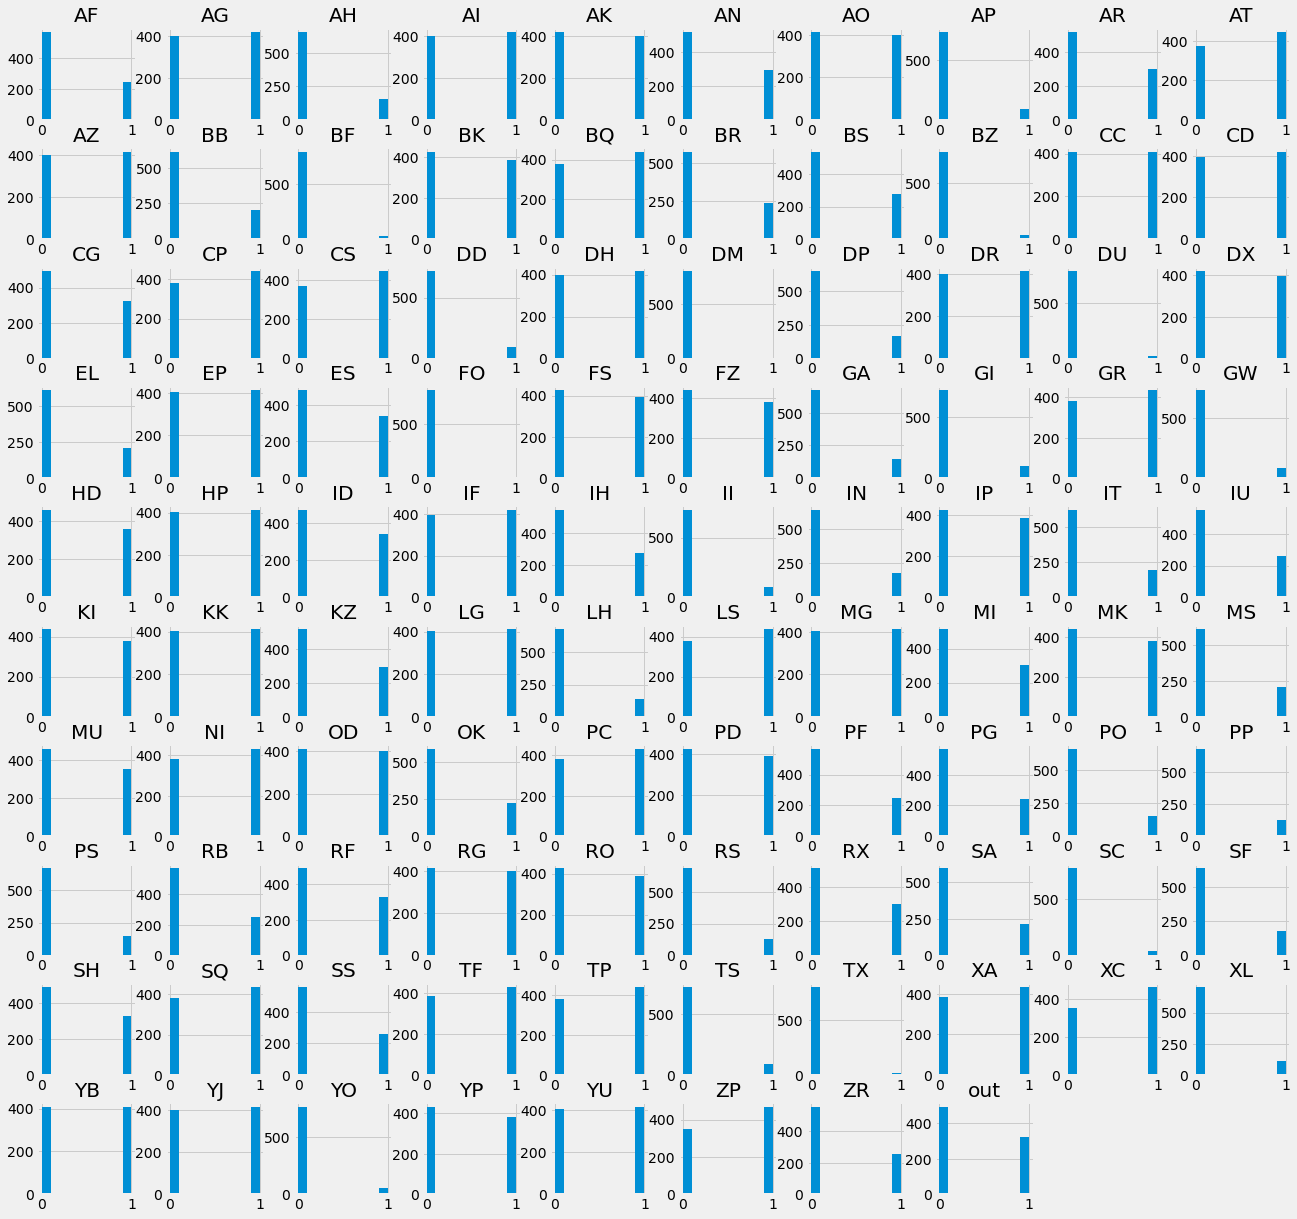

In [137]:
# selected_stocks = ['BBRI']

# broksum_selected = broksum_df[broksum_df.stock.isin(selected_stocks)]
# broksum_selected['buy'] = broksum_selected['buy'].replace({True: 1, False: 0})
# broksum_selected['volume'] = broksum_selected['volume']*100

# # print(broksum_selected)
# broksum_pivot = pd.pivot_table(broksum_selected, index=[broksum_selected.index], columns=['broker','buy']).fillna(0)
# print(broksum_pivot)
stock_df_selected = all_stocks_df[all_stocks_df.stock.isin(selected_stocks)]
print(stock_df_selected)
binary_stock_df = pd.DataFrame(np.where(stock_df_selected.close > stock_df_selected.open,1,0),index = stock_df_selected.index,columns =['out'])
print(binary_stock_df)
# stock_df_selected = pd.concat([stock_df_selected, broksum_pivot],axis =1)
stock_df_selected = pd.concat([binary_broksum_vol_net, binary_stock_df],axis =1)

# print(stock_df_selected.columns)

print(stock_df_selected)
# stock_df_selected['date'] = stock_df_selected.index
# # stock_df_selected['dayofweek'] = stock_df_selected['date'].dt.dayofweek
# # stock_df_selected['quarter'] = stock_df_selected['date'].dt.quarter
# # stock_df_selected['month'] = stock_df_selected['date'].dt.month
# # # stock_df_selected['year'] = stock_df_selected['date'].dt.year
# # stock_df_selected['dayofyear'] = stock_df_selected['date'].dt.dayofyear
# stock_df_selected['dayofmonth'] = stock_df_selected['date'].dt.day
# # stock_df_selected['weekofyear'] = stock_df_selected['date'].dt.weekofyear

# # stock_df_selected['EMA5'] = ta.EMA(stock_df_selected['close'], timeperiod=5)
# # stock_df_selected['EMA10'] = ta.EMA(stock_df_selected['close'], timeperiod=10)
# # stock_df_selected['EMA15'] = ta.EMA(stock_df_selected['close'], timeperiod=15)
# # stock_df_selected['EMA20'] = ta.EMA(stock_df_selected['close'], timeperiod=10)
# # stock_df_selected['EMA30'] = ta.EMA(stock_df_selected['close'], timeperiod=30)
# # stock_df_selected['EMA40'] = ta.EMA(stock_df_selected['close'], timeperiod=40)
# # stock_df_selected['EMA50'] = ta.EMA(stock_df_selected['close'], timeperiod=50)

# # stock_df_selected['EMA60'] = ta.EMA(stock_df_selected['close'], timeperiod=60)
# # stock_df_selected['EMA70'] = ta.EMA(stock_df_selected['close'], timeperiod=70)
# # stock_df_selected['EMA80'] = ta.EMA(stock_df_selected['close'], timeperiod=80)
# # stock_df_selected['EMA90'] = ta.EMA(stock_df_selected['close'], timeperiod=90)

# # stock_df_selected['EMA100'] = ta.EMA(stock_df_selected['close'], timeperiod=100)
# # stock_df_selected['EMA150'] = ta.EMA(stock_df_selected['close'], timeperiod=150)
# # stock_df_selected['EMA200'] = ta.EMA(stock_df_selected['close'], timeperiod=200)

# stock_df_selected['upperBB'], stock_df_selected['middleBB'], stock_df_selected['lowerBB'] = ta.BBANDS(stock_df_selected['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# stock_df_selected['SAR'] = ta.SAR(stock_df_selected['high'], stock_df_selected['low'], acceleration=0.02, maximum=0.2)

# stock_df_selected['RSI'] = ta.RSI(stock_df_selected['close'], timeperiod=14)

# # stock_df_selected['aboveEMA5'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA5'], 1, -1)
# # stock_df_selected['aboveEMA10'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA10'], 1, -1)
# # stock_df_selected['aboveEMA15'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA15'], 1, -1)
# # stock_df_selected['aboveEMA20'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA20'], 1, -1)
# # stock_df_selected['aboveEMA30'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA30'], 1, -1)
# # stock_df_selected['aboveEMA40'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA40'], 1, -1)

# # stock_df_selected['aboveEMA50'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA50'], 1, -1)
# # stock_df_selected['aboveEMA60'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA60'], 1, -1)
# # stock_df_selected['aboveEMA70'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA70'], 1, -1)
# # stock_df_selected['aboveEMA80'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA80'], 1, -1)
# # stock_df_selected['aboveEMA90'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA90'], 1, -1)

# # stock_df_selected['aboveEMA100'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA100'], 1, -1)
# # stock_df_selected['aboveEMA150'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA150'], 1, -1)
# # stock_df_selected['aboveEMA200'] = np.where(stock_df_selected['close'] > stock_df_selected['EMA200'], 1, -1)

# # stock_df_selected['aboveUpperBB'] = np.where(stock_df_selected['close'] > stock_df_selected['upperBB'], 1, -1)
# # stock_df_selected['belowlowerBB'] = np.where(stock_df_selected['close'] < stock_df_selected['lowerBB'], 1, -1)

# # stock_df_selected['aboveSAR'] = np.where(stock_df_selected['close'] > stock_df_selected['SAR'], 1, -1)

# # stock_df_selected['oversoldRSI'] = np.where(stock_df_selected['RSI'] < 30, 1, -1)
# # stock_df_selected['overboughtRSI'] = np.where(stock_df_selected['RSI'] > 70, 1, -1)


# stock_df_selected['nbsa'] = stock_df_selected['foreign_buy']-stock_df_selected['foreign_sell']
# stock_df_selected['nbsa_cumsum'] = stock_df_selected['nbsa'].cumsum()
# stock_df_selected['fn_vol'] = (stock_df_selected['foreign_buy']+stock_df_selected['foreign_sell'])/2
# # stock_df_selected['fn_buy_part'] = stock_df_selected['foreign_buy']/(2*stock_df_selected['fn_vol'])
# # stock_df_selected['fn_sell_part'] = stock_df_selected['foreign_sell']/(2*stock_df_selected['fn_vol'])
# # stock_df_selected['log_nbsa'] = np.log(stock_df_selected['foreign_buy'])-np.log(stock_df_selected['foreign_sell'])

# stock_df_selected['fn_part'] = stock_df_selected['fn_vol']/stock_df_selected['volume']
# stock_df_selected['fn_net_str'] = abs(stock_df_selected['nbsa'])/(stock_df_selected['fn_vol']*2)

# # stock_df_selected.hist(figsize=(20,20))

# stock_df_selected['log_prev'] = np.log(stock_df_selected.prev)
# stock_df_selected['log_low'] = np.log(stock_df_selected.low)
# stock_df_selected['log_high'] = np.log(stock_df_selected.high)
# # stock_df_selected['close'] = np.log(stock_df_selected.close)
# stock_df_selected['log_close'] = np.log(stock_df_selected.close)
# # stock_df_selected['volume'] = np.log(stock_df_selected.volume+1)
# # stock_df_selected['value'] = np.log(stock_df_selected.value+1)
# # stock_df_selected['freq'] = np.log(stock_df_selected.freq)
# # stock_df_selected['offer'] = stock_df_selected.offer
# # stock_df_selected['bid'] = np.log(stock_df_selected.bid+1)
# # stock_df_selected['offer_volume'] = np.log(stock_df_selected.offer_volume+1)
# # stock_df_selected['bid_volume'] = np.log(stock_df_selected.bid_volume+1)
# # stock_df_selected['nbsa_cumsum'] = stock_df_selected.nbsa_cumsum-min(stock_df_selected.nbsa_cumsum)
# # stock_df_selected[['nbsa_cumsum']] = scaler.fit_transform(stock_df_selected[['nbsa_cumsum']])
# # stock_df_selected['fn_vol'] = np.log(stock_df_selected.fn_vol+1)
# # stock_df_selected['fn_net_str'] = np.log(stock_df_selected.fn_net_str+1)

# stock_df_selected['log_ret_close'] = stock_df_selected.log_close-stock_df_selected.log_close.shift(1)
# stock_df_selected['log_ret_high'] = stock_df_selected.log_high-stock_df_selected.log_high.shift(1)
# stock_df_selected['log_ret_low'] = stock_df_selected.log_low-stock_df_selected.log_low.shift(1)
# stock_df_selected['log_ret_prev'] = stock_df_selected.log_prev-stock_df_selected.log_prev.shift(1)

# stock_df_selected.loc[stock_df_selected['log_ret_close'] == 0, 'out'] = 0 
# stock_df_selected.loc[stock_df_selected['log_ret_close'] > 0, 'out'] = 1
# stock_df_selected.loc[stock_df_selected['log_ret_close'] < 0, 'out'] = -1

# stock_df_selected['label'] = stock_df_selected['out']
# # stock_df_selected['label'] = to_categorical(stock_df_selected['label'])

# stock_df_selected = stock_df_selected.drop(columns=['date','stock', 'high','low', 'prev', 'close', 'log_low',
#                                                      'offer', 'offer_volume', 'bid', 'bid_volume',
#                                                     'log_high','change','weight_for_index','listed_shares','tradable_shares',
#                                                     'stock_name','remarks','index_individual','non_regular_volume',
#                                                     'non_regular_value', 'non_regular_freq','open_price','first_trade'])

stock_df_selected = stock_df_selected.fillna(0)

# stock_df_selected = pd.DataFrame(normalize(stock_df_selected, axis=-1, order=2))



stock_df_selected.hist(figsize=(20,20))

# print(stock_df_selected.nbsa_cumsum)
# stock_df_selected.describe()
display(stock_df_selected)

In [52]:
print(stock_df_selected.columns)

Index(['prev', 'high', 'low', 'close', 'volume', 'value', 'freq', 'dayofweek',
       'quarter', 'month', 'dayofyear', 'dayofmonth', 'weekofyear',
       'nbsa_cumsum', 'fn_vol', 'fn_part', 'fn_net_str', 'log_close',
       'log_ret_close', 'out', 'label'],
      dtype='object')


In [9]:
# print(stock_df_selected.tail(12))
print(np.any(np.isnan(stock_df_selected)))
print(np.any(np.isinf(stock_df_selected)))
print(stock_df_selected.isnull().any())



False
False
AF     False
AG     False
AH     False
AI     False
AK     False
       ...  
YP     False
YU     False
ZP     False
ZR     False
out    False
Length: 91, dtype: bool


In [138]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable

# print(stock_df_selected['log_ret'])
n_outputs=1
feature_train, label_train, feature_test, label_test = load_data(stock_df_selected, stock_df_selected.columns, Enrol_window, False, n_outputs)
print(feature_train.shape)

print(feature_test)
print(feature_test.shape)
print(label_test)
# feature_train.describe()
# stock_df_selected["log_ret"][:'2019'].plot(figsize=(16,4),legend=True)
# stock_df_selected["log_ret"]['2020':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
# plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
# plt.title('stock price')
# plt.show()

               AF          AG          AH          AI          AK          AN  \
count  816.000000  816.000000  816.000000  816.000000  816.000000  816.000000   
mean     0.301471    0.512255    0.194853    0.512255    0.488971    0.363971   
std      0.459178    0.500156    0.396330    0.500156    0.500185    0.481435   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
75%      1.000000    1.000000    0.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               AO          AP          AR          AT  ...          XC  \
count  816.000000  816.000000  816.000000  816.000000  ...  816.000000   
mean     0.492647    0.106618    0.368873    0.542892  ...    0.566176   
std      0.500253    0.308816    0.482795    0.4

In [115]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

AttributeError: 'str' object has no attribute 'decode'

In [153]:
# Note: replace LSTM with GRU or SimpleRNN if you want to try those
layer_output=1
model = Sequential()
# (feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
model.add(Conv2D(filters = 32, padding ='same', kernel_size=3,activation='relu', input_shape=(feature_train.shape[1],feature_train.shape[2],1)))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=(2), strides=2))
# model.add(Conv2D(32, padding ='same', kernel_size=3, activation='relu'))

# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(MaxPooling2D(pool_size=(2,2), strides=2))
# model.add(Conv2D(64, padding ='same', kernel_size=3, activation='relu'))
# model.add(Conv2D(64, padding ='same', kernel_size=3, activation='relu'))

# model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# model.add(Conv2D(128, padding ='same', kernel_size=3, activation='relu'))
# model.add(Conv2D(128, padding ='same', kernel_size=3, activation='relu'))

# model.add(MaxPooling2D(pool_size=(2), strides=2))

# model.add(Conv1D(512, padding ='same', kernel_size=3, activation='relu'))
# model.add(Conv1D(512, padding ='same', kernel_size=3, activation='relu'))

# model.add(MaxPooling1D(pool_size=(2), strides=2))

# model.add(GlobalAveragePooling1D())
# model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
# model.add(Dense(100, activation='sigmoid'))

# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(1024))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,feature_train.shape[1],feature_train.shape[2]))) #n_steps,n_features
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
# model.add(TimeDistributed(Dropout(0.5)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(100))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='relu'))
from keras.optimizers import Adam, SGD
# opt = Adam(lr=0.001)
opt = SGD(lr=0.01, momentum=0.9)

# model.add(Dense(layer_output, activation='softmax'))
# model.add(Dense(layer_output, activation='linear'))
model.add(Dense(layer_output, activation = "sigmoid"))

          

# model.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer= opt, loss='mse', metrics=['accuracy'])

          

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 1, 97, 32)         320       
_________________________________________________________________
flatten_35 (Flatten)         (None, 3104)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 100)               310500    
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 101       
Total params: 310,921
Trainable params: 310,921
Non-trainable params: 0
_________________________________________________________________
None


Train on 652 samples, validate on 162 samples
Epoch 1/100
652/652 [==============================] - 0s 538us/step - loss: 0.6861 - accuracy: 0.5951 - val_loss: 0.6837 - val_accuracy: 0.6049
Epoch 2/100
652/652 [==============================] - 0s 47us/step - loss: 0.6847 - accuracy: 0.6028 - val_loss: 0.6814 - val_accuracy: 0.6049
Epoch 3/100
652/652 [==============================] - 0s 54us/step - loss: 0.6823 - accuracy: 0.6012 - val_loss: 0.6784 - val_accuracy: 0.6049
Epoch 4/100
652/652 [==============================] - 0s 51us/step - loss: 0.6794 - accuracy: 0.6058 - val_loss: 0.6754 - val_accuracy: 0.6049
Epoch 5/100
652/652 [==============================] - 0s 55us/step - loss: 0.6762 - accuracy: 0.6074 - val_loss: 0.6727 - val_accuracy: 0.6049
Epoch 6/100
652/652 [==============================] - 0s 61us/step - loss: 0.6734 - accuracy: 0.6074 - val_loss: 0.6705 - val_accuracy: 0.6049
Epoch 7/100
652/652 [==============================] - 0s 58us/step - loss: 0.6711 - accu

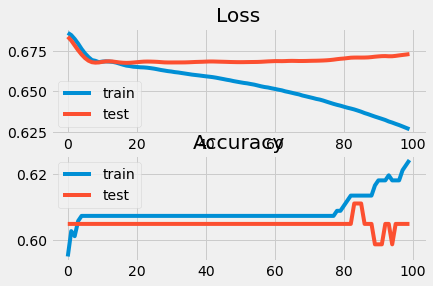

In [154]:
#Train the model
feature_train = np.reshape(feature_train, (feature_train.shape[0], feature_train.shape[1], feature_train.shape[2],1))

feature_test = np.reshape(feature_test, (feature_test.shape[0], feature_test.shape[1], feature_test.shape[2],1))
# label_test = np.reshape(label_test, (label_test.shape[0], label_test.shape[1], label_test.shape[2]))

history = model.fit(feature_train, label_train, batch_size=512, epochs=100,validation_data = (feature_test, label_test))

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
print('\n')
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [110]:
_, train_acc = model.evaluate(feature_train, label_train, verbose=0)
_, test_acc = model.evaluate(feature_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Train: 0.657, Test: 0.620
Saved model to disk


(162, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
1.0
(162,)


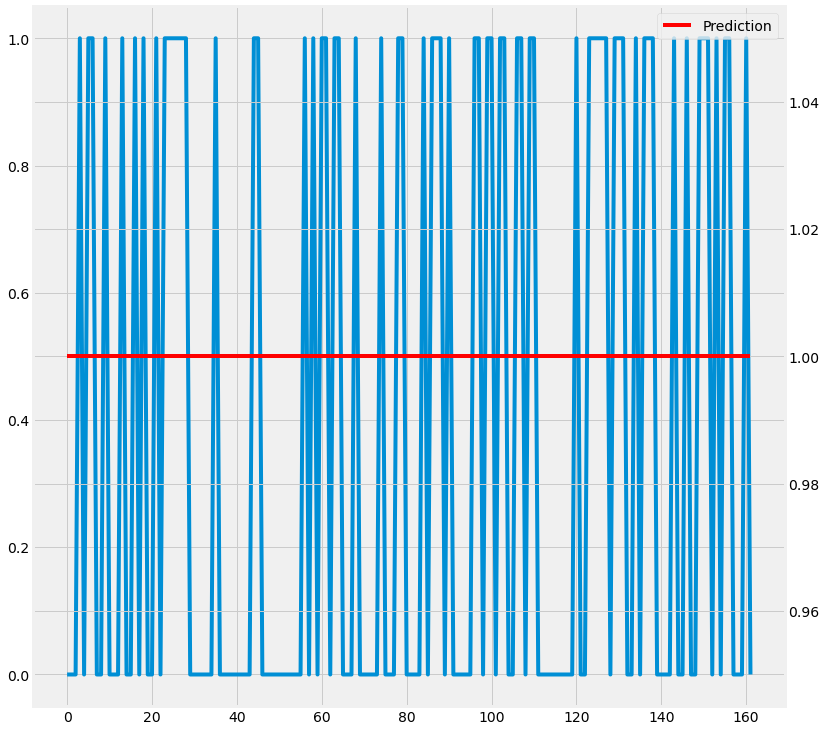

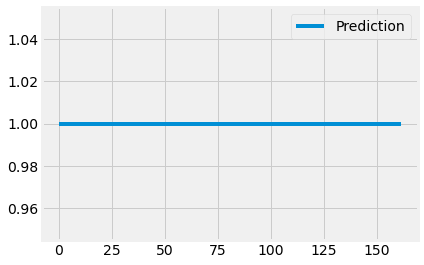

In [152]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)
# predicted_stock_price = model.predict(feature_train)

# data = pd.concat([pd.DataFrame(feature_test), pd.DataFrame(predicted_stock_price)], axis=1, ignore_index=True)

# data = scaler.inverse_transform(data)
# inv_pred = data[-1]
# print(feature_test[-1::])
# print(np.array(label_test))
print(label_test.shape)
# predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
# print(feature_test)
print(predicted_stock_price)
# print(predicted_stock_price)
print(np.mean(predicted_stock_price))
# print(predicted_stock_price)
price = []
for prc in predicted_stock_price:
    price.append(prc[0])
    
price = pd.Series(price)
price = price - price.shift(1)

# price_lst=[]
# for i in price:
#     if i[0]>=0:
#         price.append(1)
#     else:
#         price.append(0)

transform_pred = [1 if x >0.4 else 0 for x in predicted_stock_price]
# print(price)
print(price.shape)
plot_results(predicted_stock_price, label_test)
# plot_results(transform_pred, label_test)

# plot_results(predicted_stock_price, label_train)

plot_result(predicted_stock_price)

In [ ]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 60)
plot_results_multiple(predictions, label_test, 100)  